In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import math
import time
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
import dicom
import ghalton
from scipy.interpolate import interp1d
from scipy.stats import nanmean as mean
from skimage.measure import block_reduce

In [3]:
import sys
sys.path.insert(1,'./code')
from utils import clean
from get_data import get_data_all
from visualize import plot_volumes

In [5]:
list_6_4mm, list_8mm, list_10mm = get_data_all()

First, Read in high resolution dicom images

In [4]:
PathDicom = '/Users/zyzdiana/Dropbox/vNav_Test_Data/Mar_18_Test_Data/high_res/'
filenames = clean(os.listdir(PathDicom))
lstFilesDCM = []

for f in filenames:
    lstFilesDCM.append(os.path.join(PathDicom,f))
print len(lstFilesDCM)

352


In [333]:
vol_high_res = np.empty([176,256,256])
for i in xrange(176):
    ds = dicom.read_file(lstFilesDCM[i])
    vol_high_res[i,:,:] = ds.pixel_array

In [356]:
vol_high_res_5deg = np.empty([176,256,256])
for i in xrange(176):
    ds = dicom.read_file(lstFilesDCM[i])
    im = ds.pixel_array
    vol_high_res_5deg[i,:,:] = imrotate(im,10)
vol_down = downsample_cube(vol_high_res, 8)

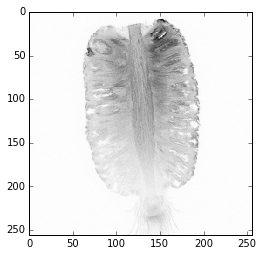

In [332]:
# Choose a slice and show Sample High Resolution Image
ds = dicom.read_file(lstFilesDCM[260])
pic = ds.pixel_array
plt.imshow(pic, interpolation='None', cmap='Greys')
plt.show()

In [323]:
def downsample_im(image,factor):
    """
    Downsample a 2D array by averaging over *factor* pixels in each axis.
    Crops upper edge if the shape is not a multiple of factor.
    """
    ys,xs = image.shape
    crarr = image[:ys-(ys % int(factor)),:xs-(xs % int(factor))]
    dsarr = mean( np.concatenate([[crarr[i::factor,j::factor] 
        for i in range(factor)] 
        for j in range(factor)]), axis=0)
    return dsarr

def downsample_cube(volume,factor,ignoredim=0):
    """
    Downsample a 3D array by averaging over *factor* pixels on the last two
    axes.
    """
    if ignoredim > 0: volume = volume.swapaxes(0,ignoredim)
    zs,ys,xs = volume.shape
    crarr = volume[:,:ys-(ys % int(factor)),:xs-(xs % int(factor))]
    #dsarr = mean(np.concatenate([[crarr[:,i::factor,j::factor] for i in range(factor)] for j in range(factor)]), axis=0)
    dsarr = mean(mean(np.concatenate([[[crarr[k::factor,i::factor,j::factor] 
                                   for k in range(factor)] 
                                  for i in range(factor)]
                                 for j in range(factor)]), axis=0),axis=0)


    if ignoredim > 0: dsarr = dsarr.swapaxes(0,ignoredim)
    return dsarr

def downsample_1d(myarr,factor):
    """
    Downsample a 1D array by averaging over *factor* pixels.
    Crops right side if the shape is not a multiple of factor.
    """
    xs = myarr.shape
    crarr = myarr[:xs-(xs % int(factor))]
    dsarr = mean( np.concatenate([[crarr[i::factor] for i in range(factor)] ]),axis=0)
    return dsarr

In [368]:
from rotation_2d import rot_cost_func
from visualize import plot_cost_func
from Bessel_Interp import bessel_cost_func

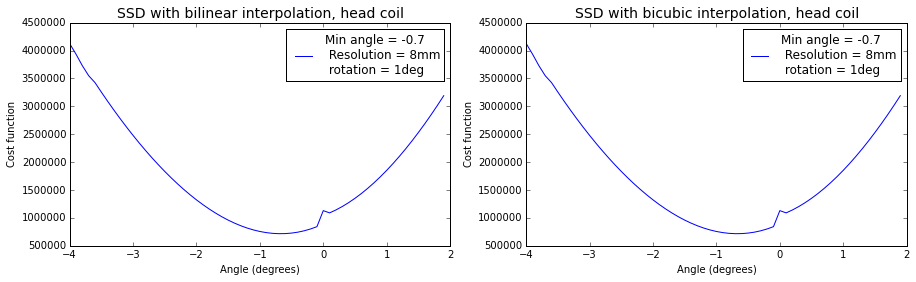

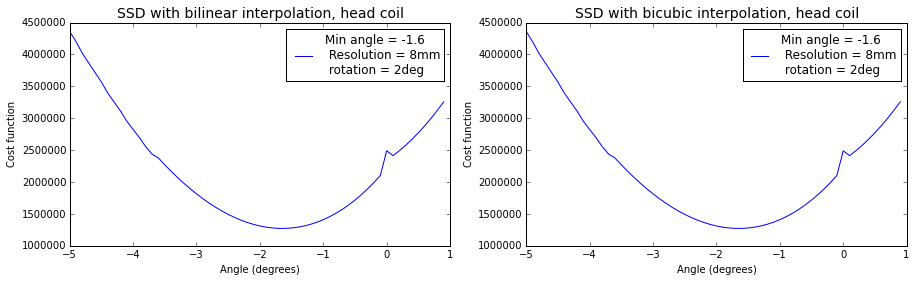

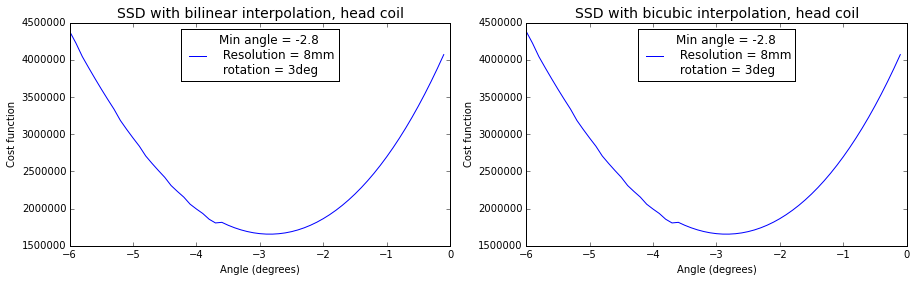

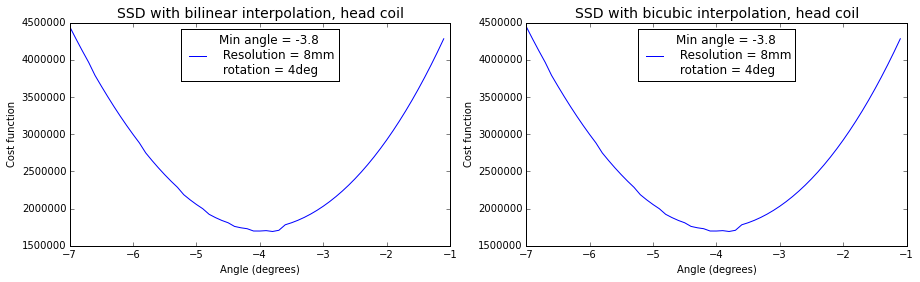

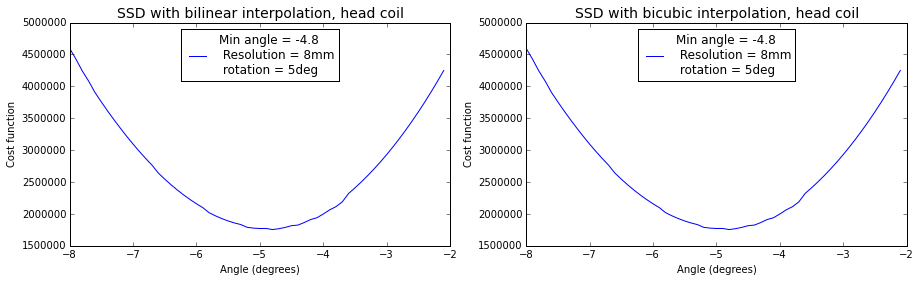

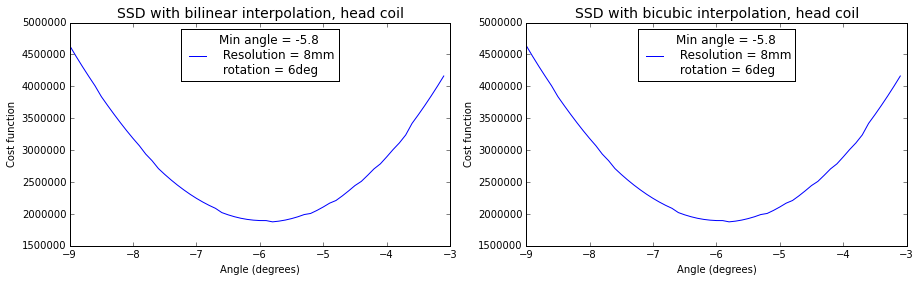

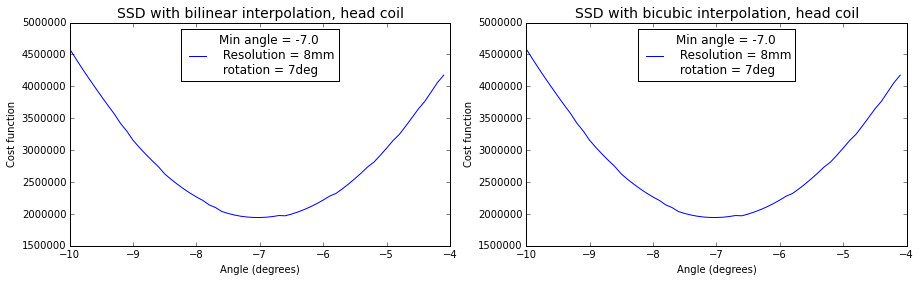

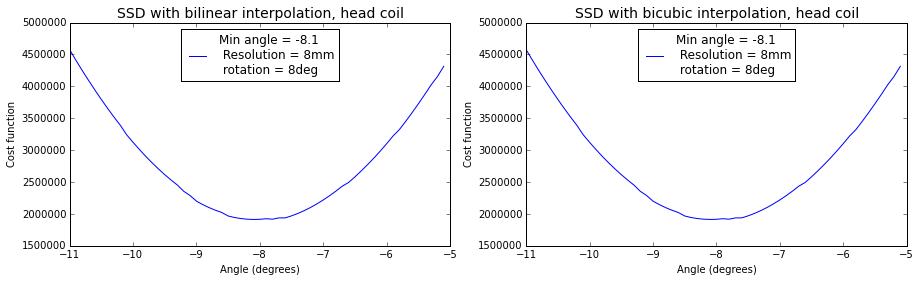

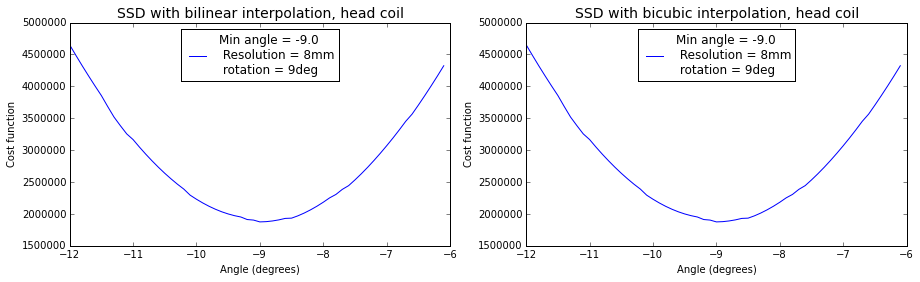

In [370]:
for deg in xrange(1,10):
    vol_high_res_5deg = np.empty([176,256,256])
    for i in xrange(176):
        ds = dicom.read_file(lstFilesDCM[i])
        im = ds.pixel_array
        vol_high_res_5deg[i,:,:] = imrotate(im,deg)
    vol_down_5deg = downsample_cube(vol_high_res_5deg, 8)
    thetas = np.arange(-deg-3,-deg+3,.1)
    cost = rot_cost_func(vol_down,vol_down_5deg,thetas,0,mask=False,smooth=True)
    plt.figure(figsize=[15,4])
    plt.subplot(1,2,1)
    plot_cost_func(thetas, cost, '8mm', 'bilinear',str(deg)+'deg', 'head')
    plt.subplot(1,2,2)
    cost_cubic = rot_cost_func(vol_down,vol_down_5deg,thetas,0,interpolation='bicubic',mask=False,smooth=True)
    plot_cost_func(thetas, cost, '8mm', 'bicubic',str(deg)+'deg', 'head')
    plt.show()

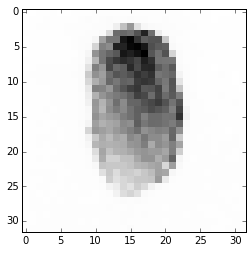

In [325]:
# Downsample the chosen slice, Example Downsample
pic_red1 = downsample_im(pic,8)
plt.imshow(pic_red, interpolation='None', cmap='Greys')
plt.show()

In [135]:
from rotation_2d import imrotate
from Bessel_Interp import bessel_rotate
from cost_functions import cf_ssd

In [153]:
def rot_downsample(image, theta, block_size = (8,8)):
    if(theta == 0):
        return block_reduce(image, block_size=block_size, func=np.mean)
    else:
        tmp = imrotate(image, theta)
        return block_reduce(tmp, block_size=block_size, func=np.mean)

In [154]:
def downsample(pic, ang, block_size, thetas, interpolation):
    im1 = rot_downsample(pic, 0, block_size = block_size)
    im2 = rot_downsample(pic, ang, block_size = block_size)
    cost_func = np.zeros([len(thetas)])
    cost_func_mask = np.zeros([len(thetas)])
    for idx,th in enumerate(thetas):
        if(interpolation == 'bessel'):
            rot_im2 = bessel_rotate(im2, th)
            rot_im2_mask = bessel_rotate(im2, th,mask=True,smooth=True)
        else:
            rot_im2 = imrotate(im2, th)
            rot_im2_mask = imrotate(im2, th, interpolation, mask=True,smooth=True)
        cost_func[idx] = cf_ssd(rot_im2, im1)
        cost_func_mask[idx] = cf_ssd(rot_im2_mask,im1)
    angMin = thetas[np.argmin(cost_func)]
    angMin_mask = thetas[np.argmin(cost_func_mask)]
    plt.plot(thetas, cost_func,label='Without Mask\n Min angle = %s' %angMin)
    plt.plot(thetas, cost_func,label='With Mask\n Min angle = %s' %angMin_mask)
    plt.title('%s interpolation, blocksize = %s' % (interpolation, block_size))
    plt.xlabel('Angles (Degrees)')
    plt.ylabel('SSD')
    plt.legend()
    plt.show()

##Registration on Downsampled images

I selected a slice from the high resolution image, and rotated the high res image by 5 degrees, then I downsampled both the original high res image (target) and the rotated high res image (source) with three different block sizes. Registration on the two images are then performed using bessel, linear and cubic interpolation.

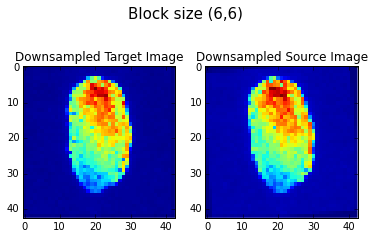

In [138]:
ang=5
im1 = rot_downsample(pic, 0, block_size = (6,6))
im2 = rot_downsample(pic, ang, block_size = (6,6))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1,interpolation='None')
ax[0].set_title('Downsampled Target Image')
ax[1].imshow(im2, interpolation='None')
ax[1].set_title('Downsampled Source Image')
plt.suptitle('Block size (6,6)', fontsize=15)
plt.show()
plt.close(fig)

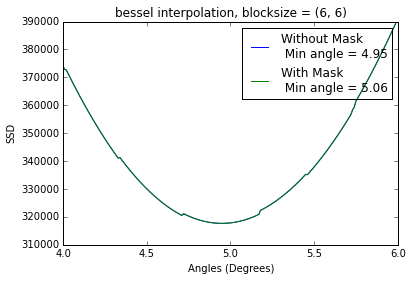

In [139]:
# 6 by 6  resolution bessel interpolation
thetas = np.arange(4,6,0.01)
downsample(pic, 5, (6,6), thetas, interpolation='bessel')

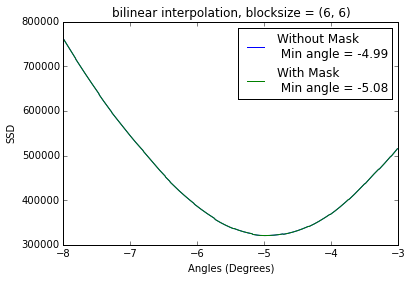

In [140]:
# 6 by 6  resolution linear interpolation
thetas = np.arange(-8,-3,0.01)
downsample(pic, 5, (6,6), thetas, interpolation='bilinear')

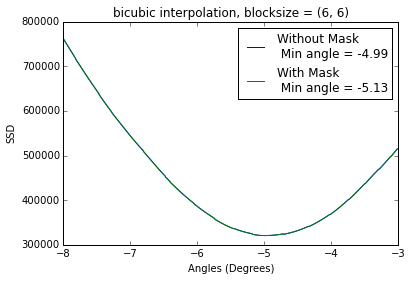

In [141]:
# 6 by 6  resolution linear interpolation
thetas = np.arange(-8,-3,0.01)
downsample(pic, 5, (6,6), thetas, interpolation='bicubic')

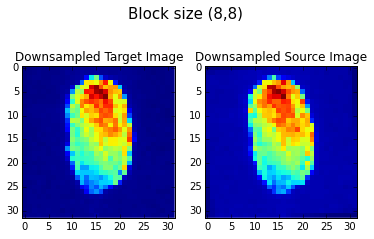

In [142]:
ang=5
im1 = rot_downsample(pic, 0, block_size = (8,8))
im2 = rot_downsample(pic, ang, block_size = (8,8))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1,interpolation='None')
ax[0].set_title('Downsampled Target Image')
ax[1].imshow(im2, interpolation='None')
ax[1].set_title('Downsampled Source Image')
plt.suptitle('Block size (8,8)', fontsize=15)
plt.show()
plt.close(fig)

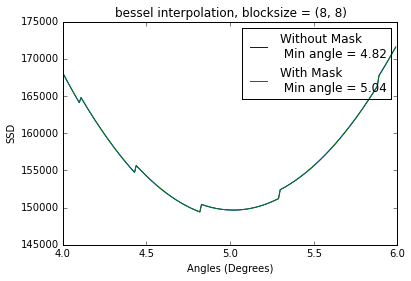

In [143]:
# 8 by 8  resolution
thetas = np.arange(4,6,0.01)
downsample(pic, 5, (8,8), thetas, interpolation='bessel')

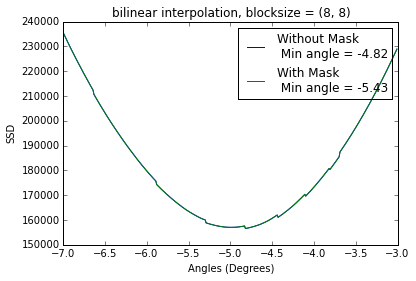

In [144]:
# 8 by 8  resolution
thetas = np.arange(-7,-3,0.01)
downsample(pic, 5, (8,8), thetas, interpolation='bilinear')

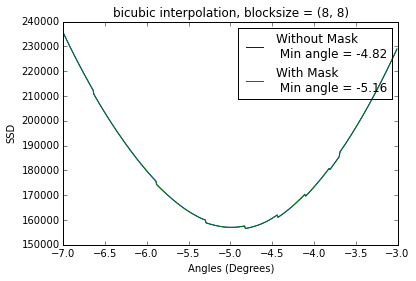

In [145]:
# 8 by 8  resolution
thetas = np.arange(-7,-3,0.01)
downsample(pic, 5, (8,8), thetas, interpolation='bicubic')

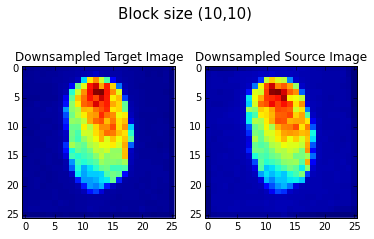

In [146]:
ang=5
im1 = rot_downsample(pic, 0, block_size = (10,10))
im2 = rot_downsample(pic, ang, block_size = (10,10))
fig, ax = plt.subplots(1,2)
ax[0].imshow(im1,interpolation='None')
ax[0].set_title('Downsampled Target Image')
ax[1].imshow(im2, interpolation='None')
ax[1].set_title('Downsampled Source Image')
plt.suptitle('Block size (10,10)', fontsize=15)
plt.show()
plt.close(fig)

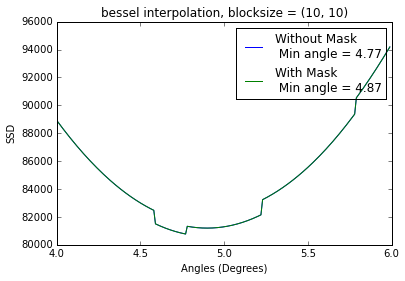

In [147]:
# 10 by 10  resolution
thetas = np.arange(4,6,0.01)
downsample(pic, 5, (10,10), thetas, interpolation='bessel')

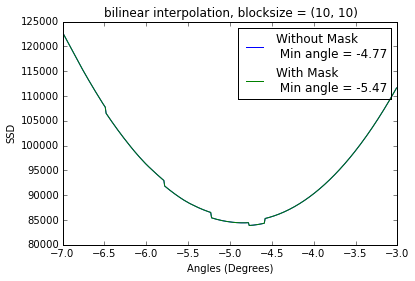

In [148]:
# 10 by 10  resolution
thetas = np.arange(-7,-3,0.01)
downsample(pic, 5, (10,10), thetas, interpolation='bilinear')

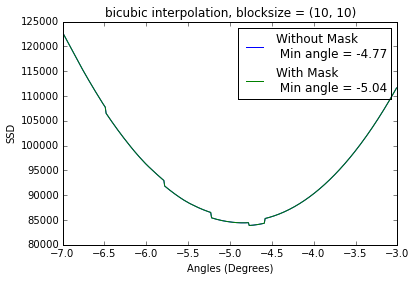

In [149]:
# 10 by 10  resolution
thetas = np.arange(-7,-3,0.01)
downsample(pic, 5, (10,10), thetas, interpolation='bicubic')

In [ ]:
min_angles_bess = {}
angles = np.arange(5,90,0.01)
for ang in angles:
    if(ang%10==0): print ang,
    im1, im2 = rot_downsample(pic, ang, block_size = (8,8))
    thetas = np.arange(ang-3, ang+3, 0.1)
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        new_im2 = bessel_rotate(im2, th)
        cost_func[idx] = cf_ssd(new_im2, im1)
    angMin = thetas[np.argmin(cost_func)]
    min_angles_bess[ang] = angMin

In [49]:
min_angles_bess_6 = {}
angles = np.arange(-6,6,0.1)
for ang in angles:
    if(ang%10==0): print ang,
    im1, im2 = rot_downsample(pic, ang, block_size = (6,6))
    thetas = np.arange(ang-3, ang+3, 0.1)
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        new_im2 = bessel_rotate(im2, th)
        cost_func[idx] = cf_ssd(new_im2, im1)
    angMin = thetas[np.argmin(cost_func)]
    min_angles_bess_6[ang] = angMin

In [ ]:
plt.plot(thetas, cost_func,label='Min angle = %s' %angMin)
plt.title('SSD of Downsampled Images, Blocksize = (6,6)')
plt.xlabel('Angles (Degrees)')
plt.ylabel('SSD')
plt.legend()
plt.show()

In [13]:
min_angles_bess_10 = {}
angles = np.arange(0,30,0.01)
for ang in angles:
    if(ang%10==0): print ang,
    im1, im2 = rot_downsample(pic, ang, block_size = (10,10))
    thetas = np.arange(ang-3, ang+3, 0.1)
    cost_func = np.zeros(len(thetas))
    for idx, th in enumerate(thetas):
        new_im2 = bessel_rotate(im2, th)
        cost_func[idx] = cf_ssd(new_im2, im1)
    angMin = thetas[np.argmin(cost_func)]
    min_angles_bess_10[ang] = angMin

0.0 10.0 20.0


In [14]:
import cPickle as pickle
pickle.dump(min_angles_bess, open('blocksize_8_min_angles_0_01.p','wb'))
pickle.dump(min_angles_bess_6, open('blocksize_6_min_angles_0_01.p','wb'))
pickle.dump(min_angles_bess_10, open('blocksize_10_min_angles_0_01.p','wb'))

In [103]:
#import cPickle as pickle
#pickle.dump(min_angles_bess, open('blocksize_8_min_angles.p','wb'))
#pickle.dump(min_angles_bess_6, open('blocksize_6_min_angles.p','wb'))
#pickle.dump(min_angles_bess_10, open('blocksize_10_min_angles.p','wb'))

In [15]:
# Sort the results
y = []
x = sorted(min_angles_bess.keys())
for k in x:
    y.append(min_angles_bess[k])
x = np.array(x[1:])
y = np.array(y[1:])
diff = abs(y-x)/x

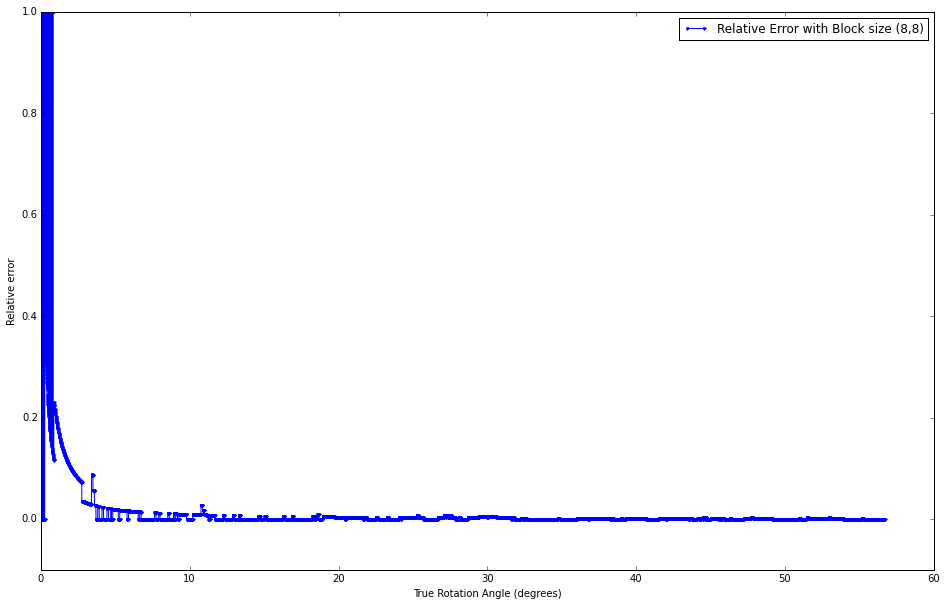

In [16]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x,diff,'.-',label='Relative Error with Block size (8,8)')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Relative error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

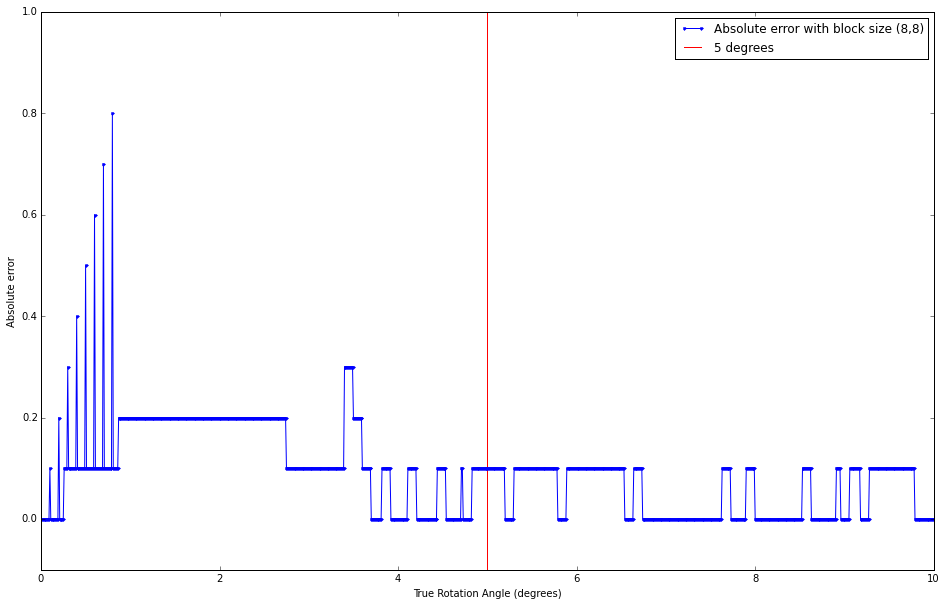

In [21]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[:1000],abs(y-x)[:1000],'.-', label='Absolute error with block size (8,8)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

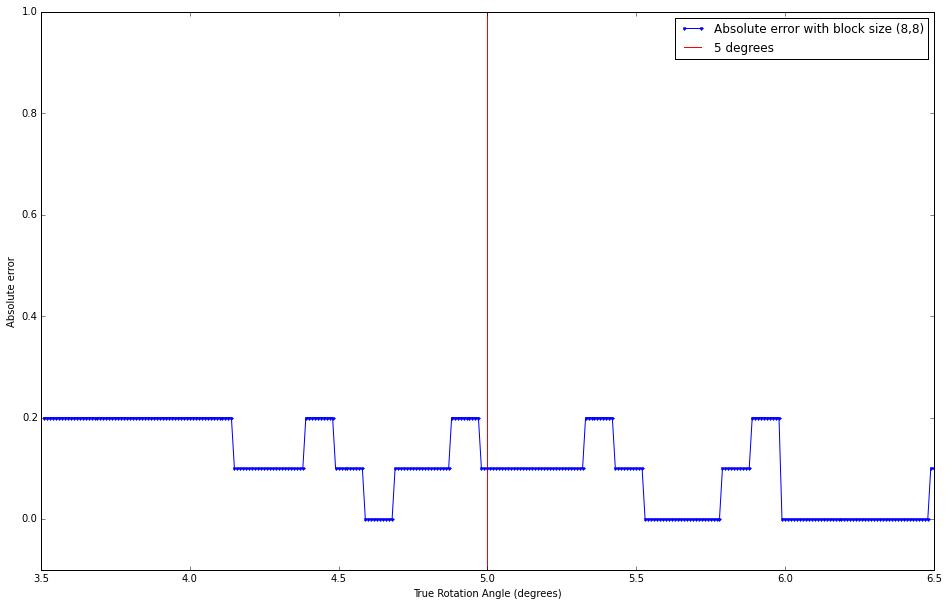

In [30]:
# Zoomed in at 5 degrees
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[350:650],abs(y-x)[350:650],'.-', label='Absolute error with block size (8,8)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

In [37]:
# Sort the results
y = []
x = sorted(min_angles_bess_6.keys())
for k in x:
    y.append(min_angles_bess_6[k])
x = np.array(x[1:])
y = np.array(y[1:])
diff = abs(y-x)/x

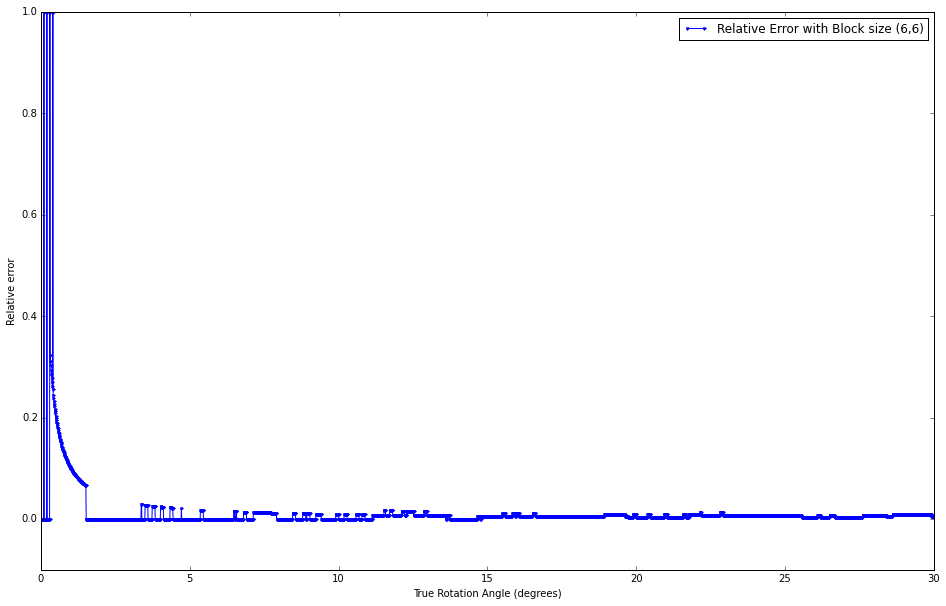

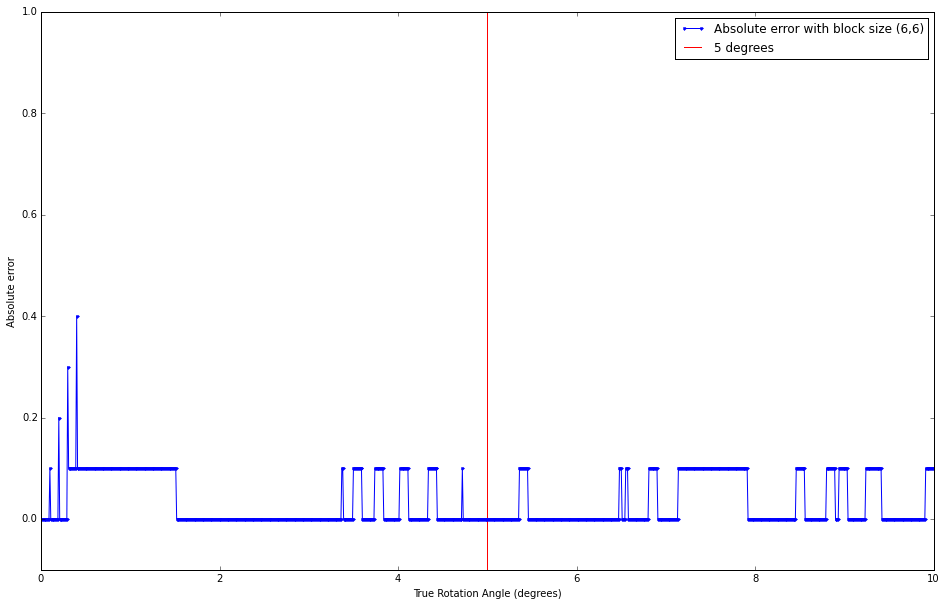

In [38]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x,diff,'.-',label='Relative Error with Block size (6,6)')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Relative error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[:1000],abs(y-x)[:1000],'.-', label='Absolute error with block size (6,6)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

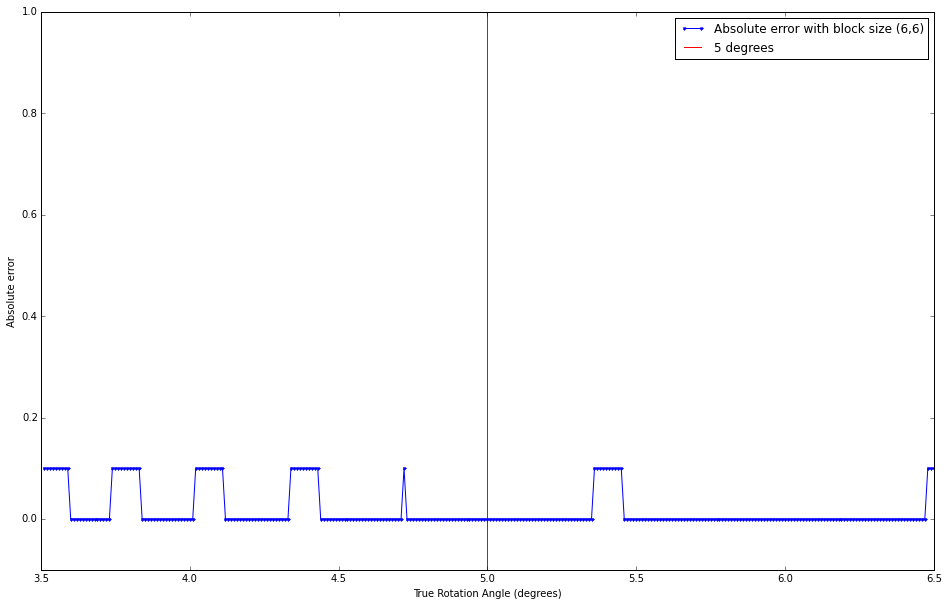

In [39]:
# Zoomed in at 5 degrees
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[350:650],abs(y-x)[350:650],'.-', label='Absolute error with block size (6,6)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

In [40]:
# Sort the results
y = []
x = sorted(min_angles_bess_10.keys())
for k in x:
    y.append(min_angles_bess_10[k])
x = np.array(x[1:])
y = np.array(y[1:])
diff = abs(y-x)/x

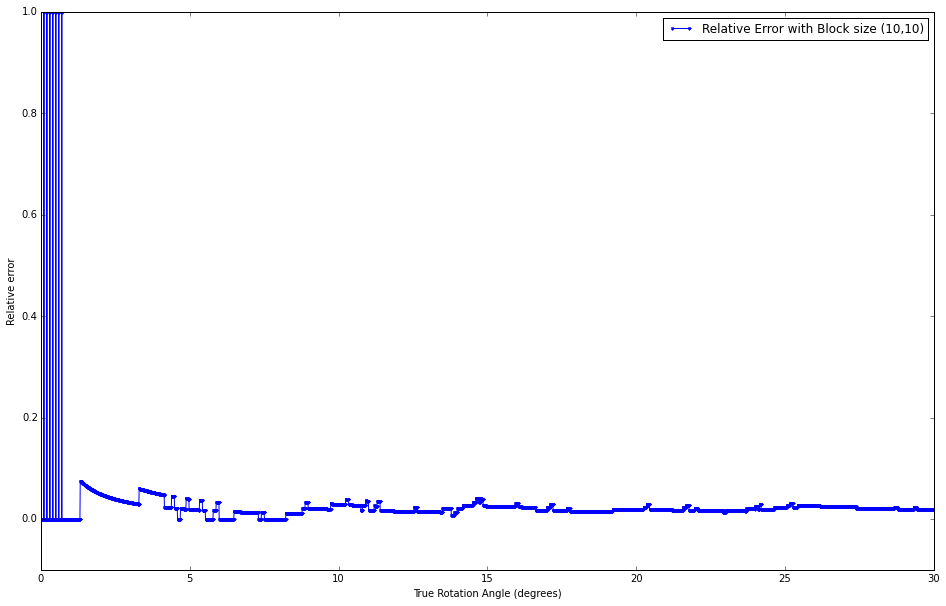

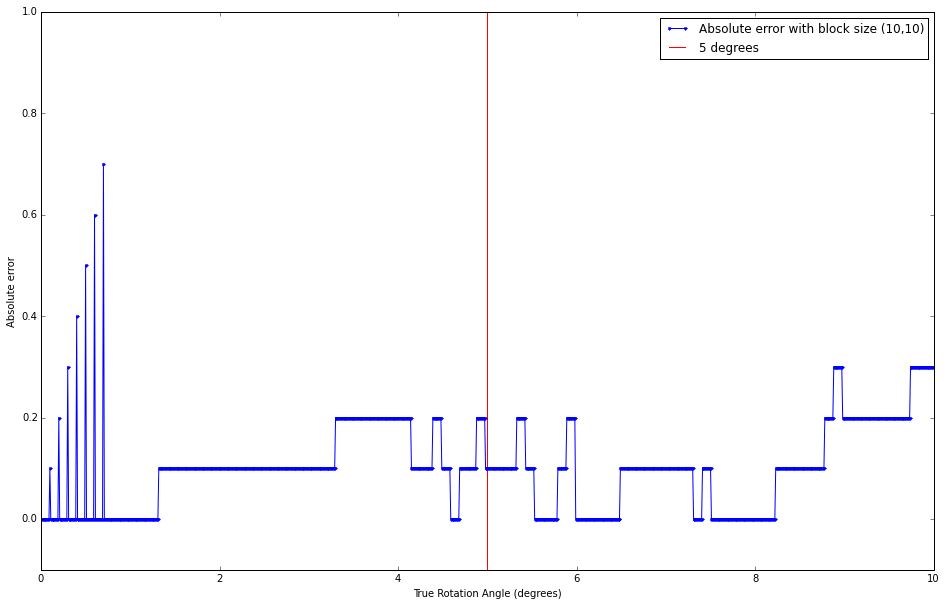

In [41]:
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x,diff,'.-',label='Relative Error with Block size (10,10)')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Relative error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[:1000],abs(y-x)[:1000],'.-', label='Absolute error with block size (10,10)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()

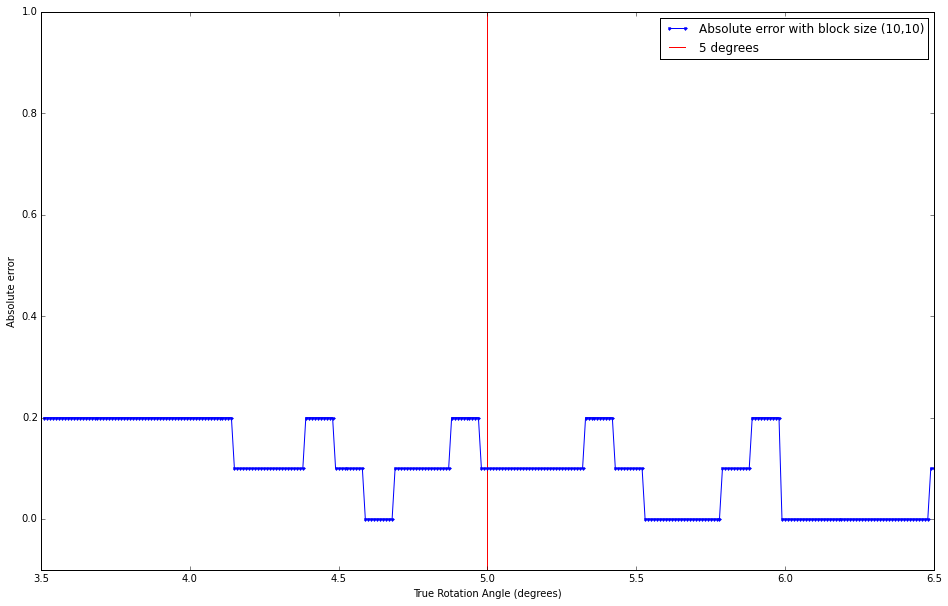

In [42]:
# Zoomed in at 5 degrees
# Plot the difference
plt.figure(figsize=[16,10])
plt.plot(x[350:650],abs(y-x)[350:650],'.-', label='Absolute error with block size (10,10)')
plt.vlines(5,-0.1,1,'r',label='5 degrees')
plt.xlabel('True Rotation Angle (degrees)')
plt.ylabel('Absolute error')
plt.ylim([-0.1,1])
plt.legend()
plt.show()